In [1]:
import json
from pathlib import Path
from pprint import pprint
import pandas as pd
from datetime import timedelta
from itertools import product

/home/ross/coding/modular_trader/records/trail_fractals_1h_None_5_2_1d_volumes_30/perf_log.json
Perf log contains 2096 observations
Within lookback period, perf log has 155 observations

/home/ross/coding/modular_trader/records/trail_fractals_1h_None_5_2_1w_volumes_30/perf_log.json
Perf log contains 342 observations
Within lookback period, perf log has 155 observations

/home/ross/coding/modular_trader/records/trail_fractals_4h_None_5_2_1d_volumes_30/perf_log.json
Perf log contains 632 observations
Within lookback period, perf log has 41 observations

/home/ross/coding/modular_trader/records/trail_fractals_4h_None_5_2_1w_volumes_30/perf_log.json
Perf log contains 76 observations
Within lookback period, perf log has 41 observations

/home/ross/coding/modular_trader/records/trail_fractals_12h_None_5_2_1d_volumes_30/perf_log.json
Perf log contains 202 observations
Within lookback period, perf log has 14 observations

/home/ross/coding/modular_trader/records/trail_fractals_12h_None_5_2_1w_

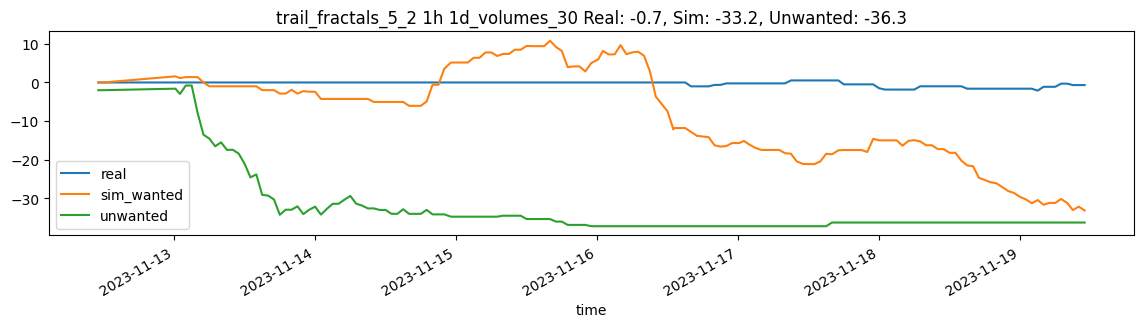

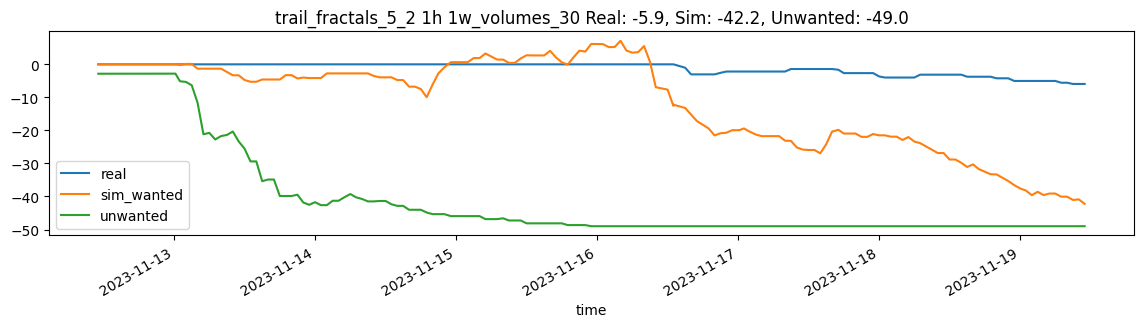

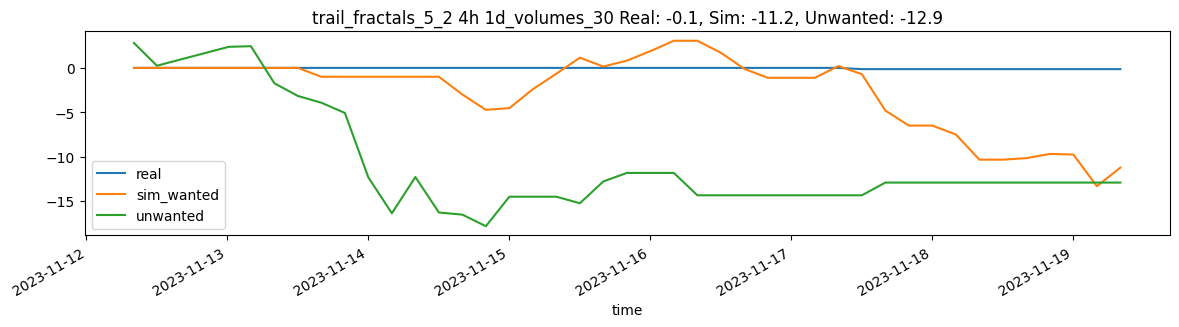

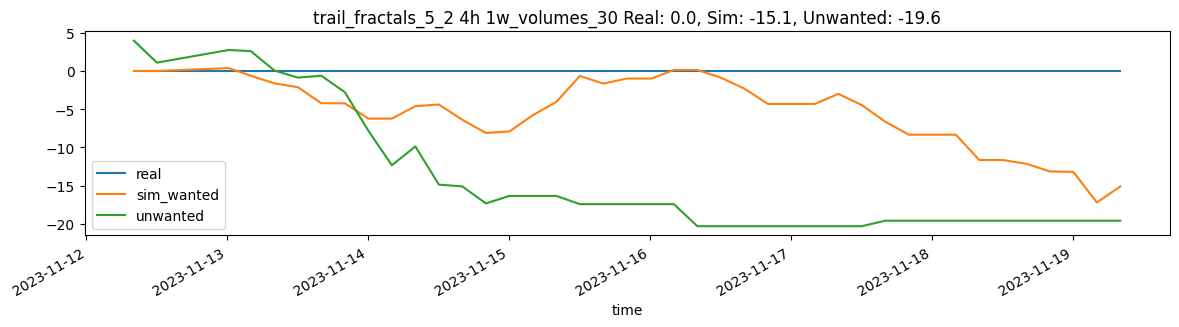

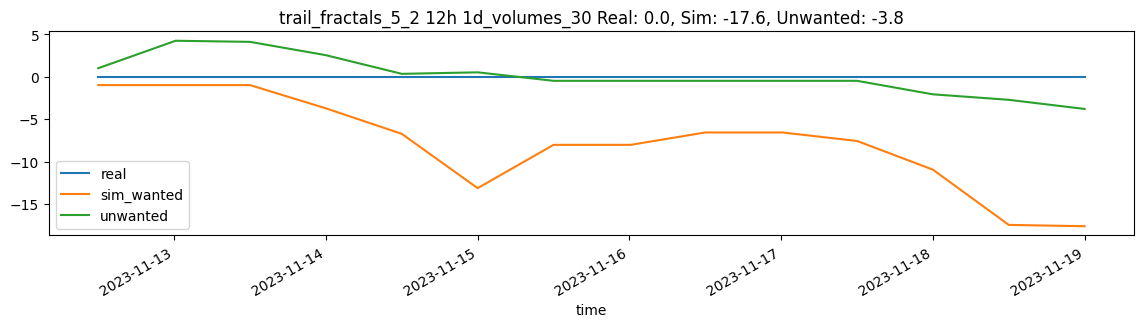

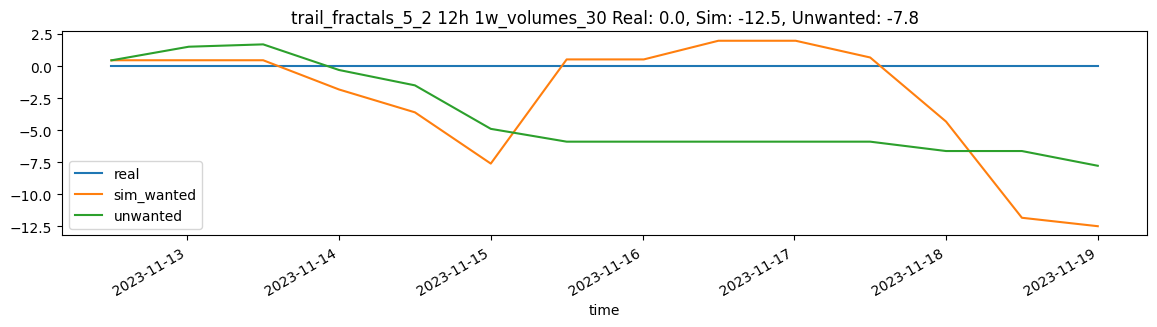

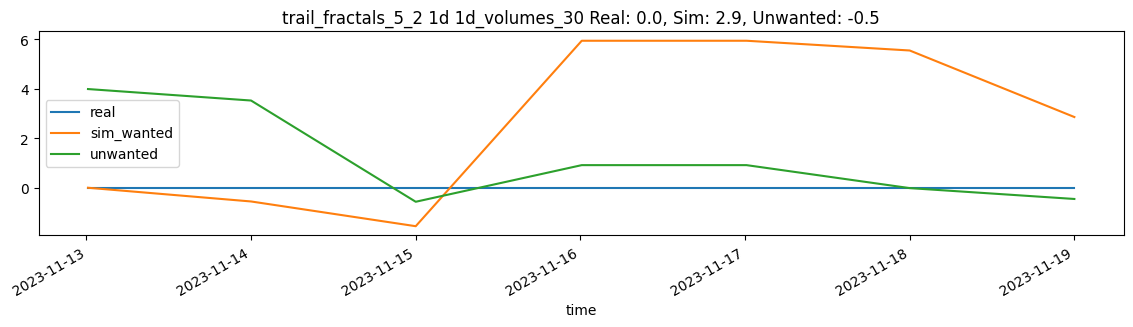

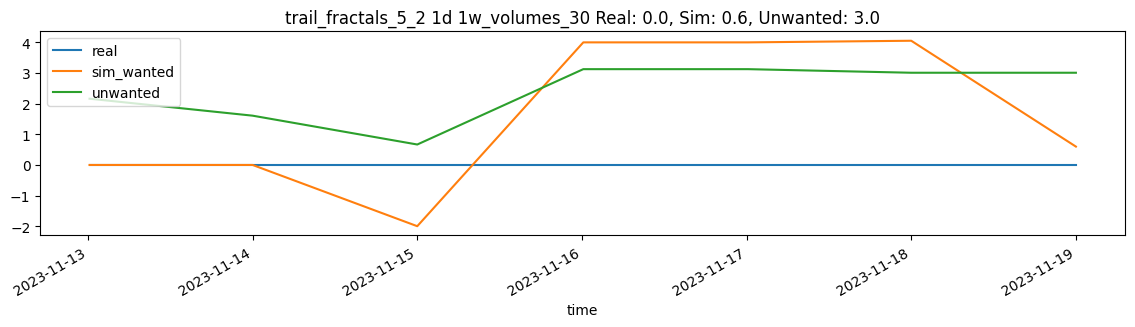

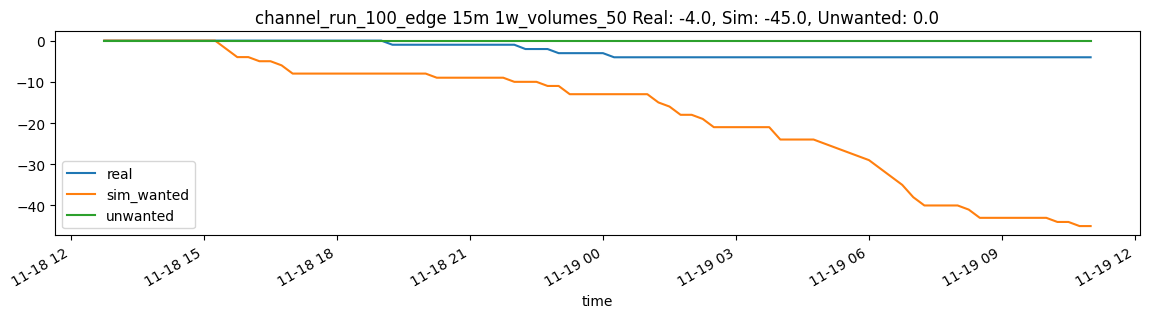

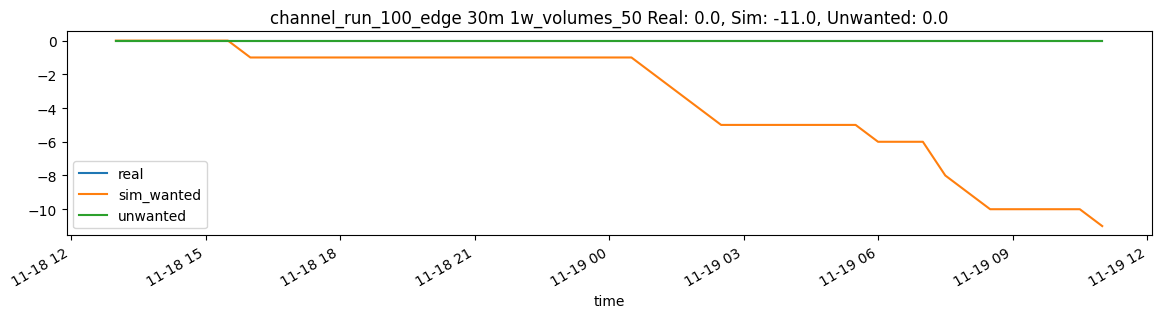

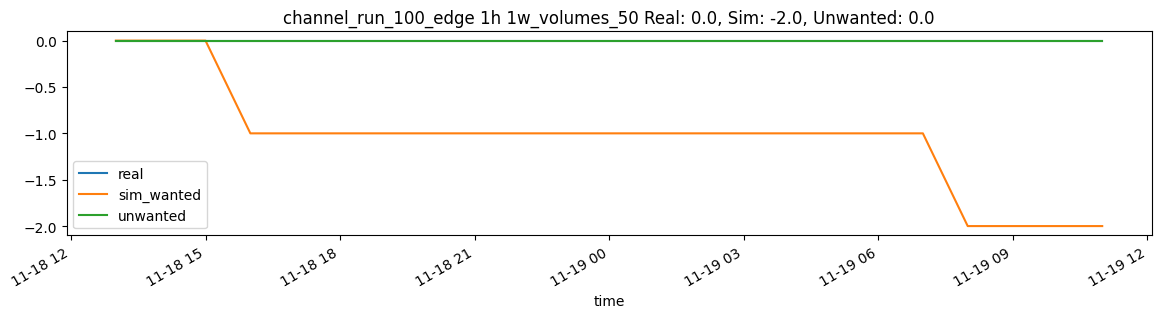

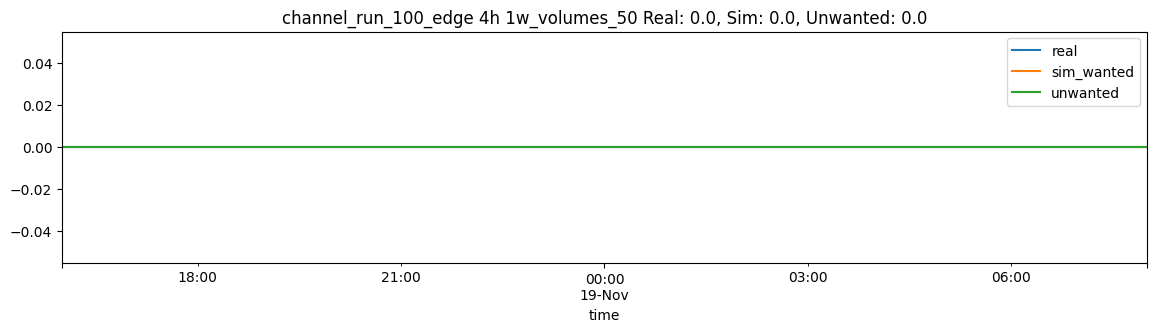

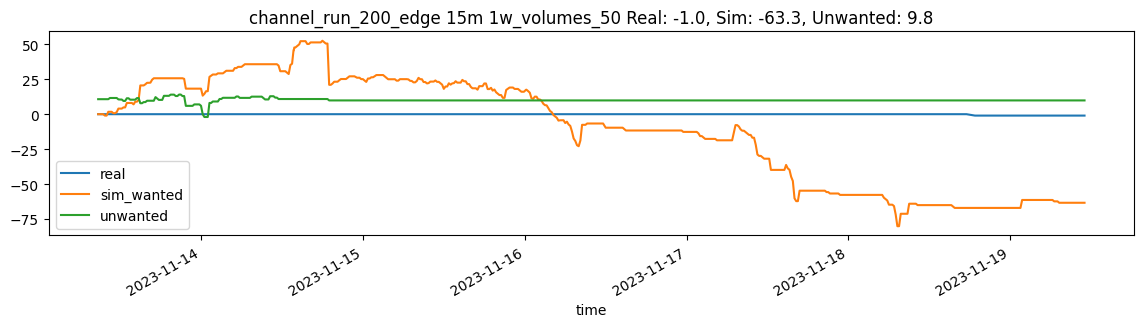

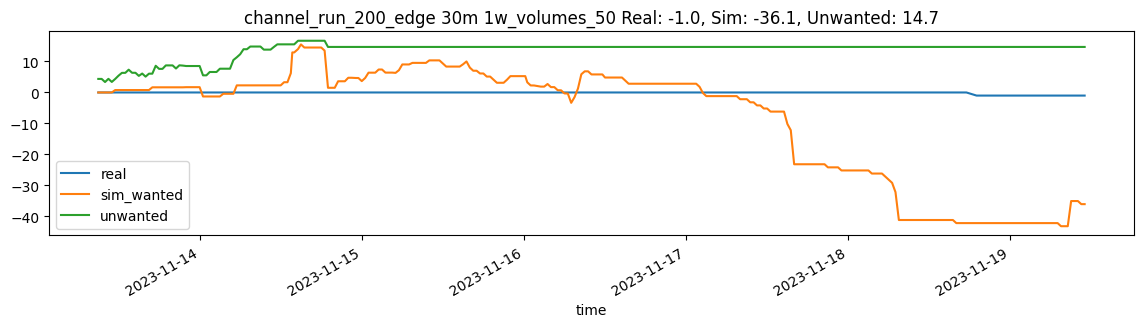

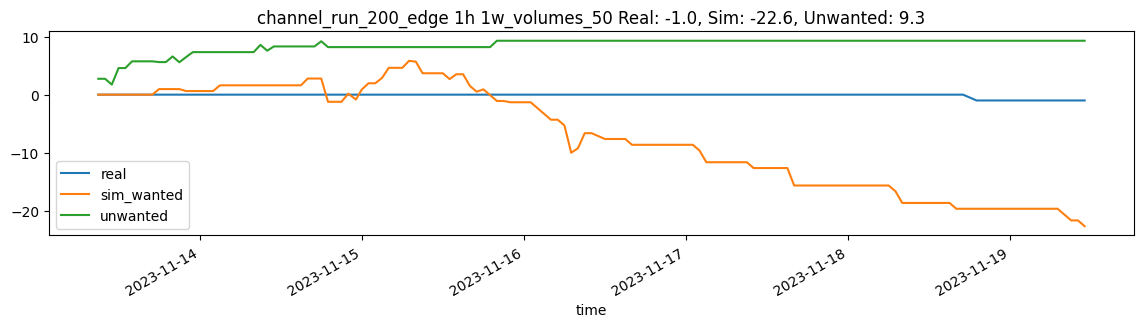

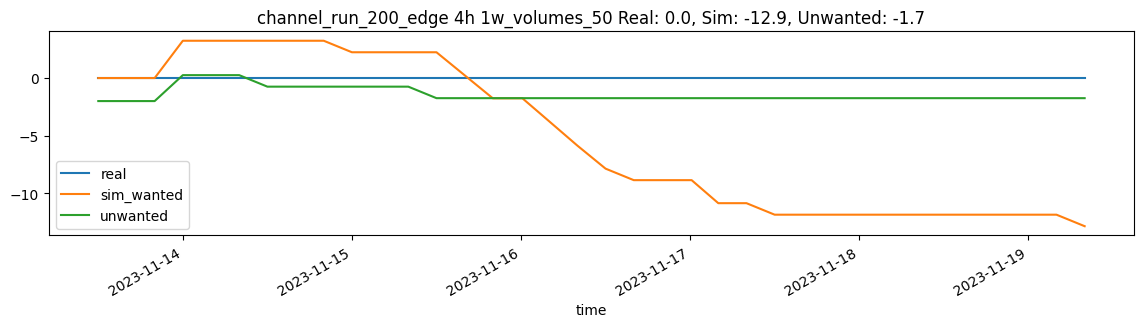

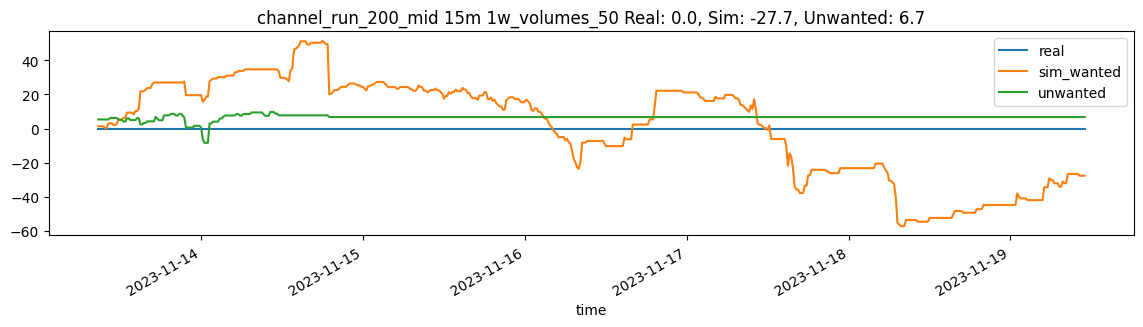

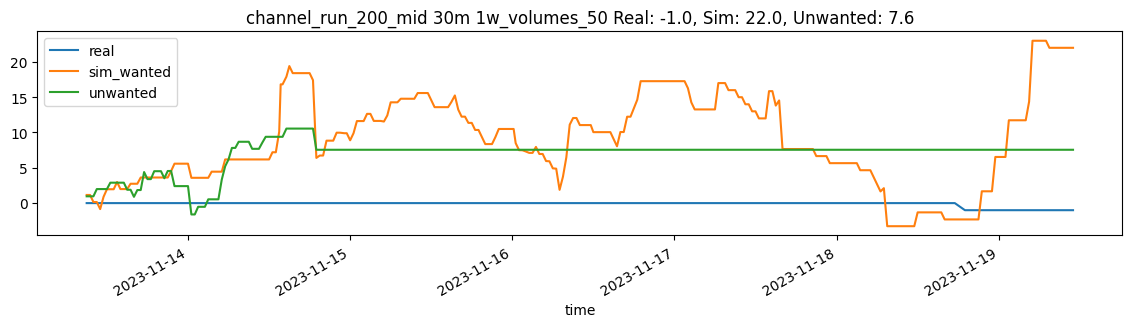

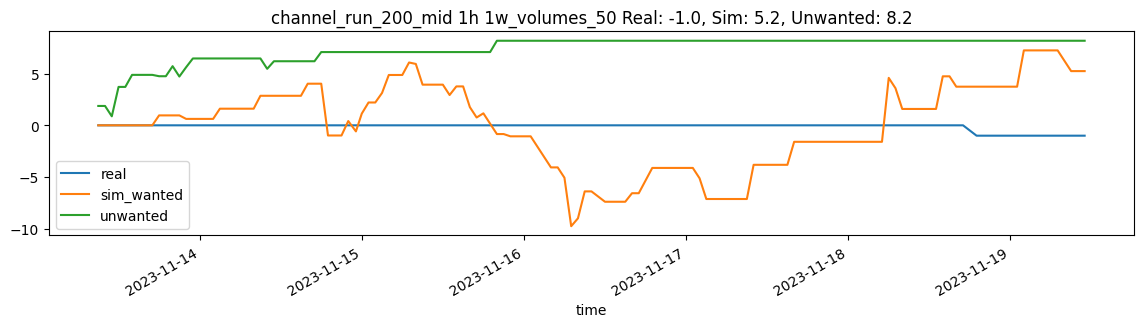

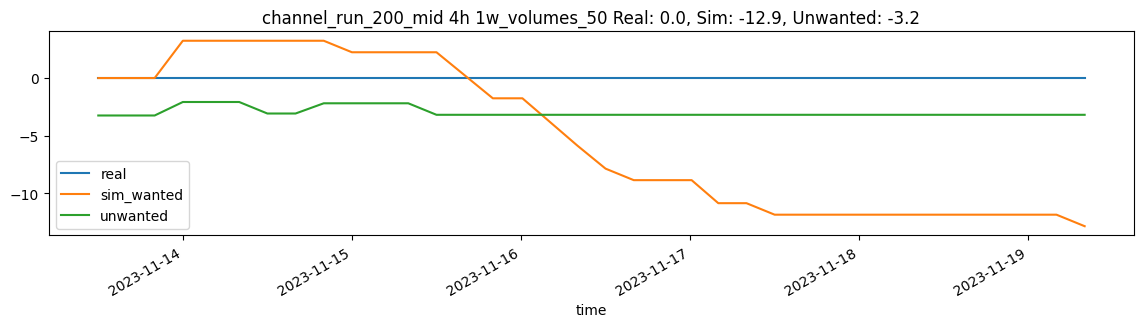

In [60]:
records = {'laptop': ['/'], 'pi': ['/pi_1/', '/pi_2/']}

strategies = [('trail_fractals', '5_2'), ('channel_run', '100_edge'), ('channel_run', '200_edge'), ('channel_run', '200_mid')]
timeframes = ['15m', '30m', '1h', '4h', '12h', '1d']
selections = ['1d_volumes_30', '1w_volumes_30', '1w_volumes_50', '1w_volumes_150']

data_sets = dict()
for machine, strat, tf, sel in product(records['laptop'], strategies, timeframes, selections):
    log_path = Path(f"/home/ross/coding{machine}modular_trader/records/{strat[0]}_{tf}_None_{strat[1]}_{sel}/perf_log.json")
    if not log_path.exists():
        continue
    with open(log_path, 'r') as file:
        print(log_path)
        try:
            perf_log = json.load(file)
        except json.JSONDecodeError:
            continue
    print(f"Perf log contains {len(perf_log)} observations")
    
    perf_stats = [{'time': d['timestamp'],
                   # 'bal': d['balance'],
                   'real_l': d['real_rpnl_long'],
                   'sim_l': d['sim_rpnl_long'],
                   'wanted_l': d['wanted_rpnl_long'],
                   'unwanted_l': d['unwanted_rpnl_long'],
                   'real_s': d['real_rpnl_short'],
                   'sim_s': d['sim_rpnl_short'],
                   'wanted_s': d['wanted_rpnl_short'],
                   'unwanted_s': d['unwanted_rpnl_short'],
                   'real_tor': d.get('real_open_risk', 0),
                   'wanted_tor': d.get('wanted_open_risk', 0),
                   'positions': d.get('num_wanted_pos', 6)
                   } for d in perf_log]
    perf_df = pd.DataFrame(perf_stats)
    perf_df['r'] = (perf_df.real_l + perf_df.real_s)
    perf_df['u'] = (perf_df.unwanted_l + perf_df.unwanted_s)
    perf_df['sw'] = (perf_df.sim_l + perf_df.sim_s) - perf_df['u']
    perf_df = perf_df.drop(['real_l', 'real_s', 'sim_l', 'sim_s', 'wanted_l', 'wanted_s', 'unwanted_l', 'unwanted_s'], axis=1)
    perf_df['time'] = pd.to_datetime(perf_df.time, format='%d/%m/%y %H:%M')
    perf_df = perf_df.set_index('time', drop=True)
    df = perf_df.sort_index()
    df = df.fillna(0)    
    lookback = (df.index[-1] - timedelta(weeks=1))
    df = df.loc[df.index > lookback]
    print(f"Within lookback period, perf log has {len(df)} observations\n")
    
    df['real'] = df.r.cumsum()
    df['sim_wanted'] = df.sw.cumsum()
    df['unwanted'] = df.u.cumsum()
    
    # df['avg_open_risk'] = df.wanted_tor / df.positions
    # df['adj_open_risk'] = df.wanted_tor - df.positions
    # df['total_wanted_pnl'] = df.real + df.sim_wanted + df.adj_open_risk
    
    df = df[['real', 'sim_wanted', 'unwanted', 
             # 'total_wanted_pnl', 'wanted_tor', 'positions'
             ]]
    data_sets[f"{strat[0]}_{strat[1]} {tf} {sel}"] = df
for agent in data_sets:
    t = f"{agent} Real: {data_sets[agent].real.iloc[-1]:.1f}, Sim: {data_sets[agent].sim_wanted.iloc[-1]:.1f}, Unwanted: {data_sets[agent].unwanted.iloc[-1]:.1f}"#, Realised + open pnl: {data_sets[agent].total_wanted_pnl.iloc[-1]:.1f}"
    data_sets[agent].plot(title=t, figsize=(14, 3), legend='upper left')